In [1]:
# # If you are importing dataset from Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import torch
import random
import numpy as np
from PIL import Image

# Creating custom random geometriic mask generator for adversarial training
class generator(object):
    """Add horiizontal line to the given image randomly with a given probability.

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (Pillow): Image to be perturbed.

        Returns:
            Pillow: Randomly added horizontal line to image.
        """
        if torch.rand(1) < self.p:
            selector = random.randint(0, 2)
            if (selector == 0):
              return F_hline(img)
            elif (selector == 1):
              return F_vline(img)
            elif (selector == 2):
              return F_spot(img)
        return img

    def __repr__(self):
        return self.__class__.__name__+'()'


def F_hline(img):
  img = np.array(img)            # PIL -> numpy
  rgb = get_rgb(img)
  h, w = img.shape[:2]
  # print(img.shape)
  thickness = random.randint(1, int(h/2))
  x = random.randint(0,w-thickness)
  y = random.randint(0,h-thickness)
  # print(f'thickness: {thickness}')
  # print(f'y: {y}')
  
  spot = np.full((160, 105), False, dtype=bool)
  for i in range(y, y+thickness, 1):
      spot[i, :] = True

  sample = img.copy()

  sample[spot, 0] = rgb['r']
  sample[spot, 1] = rgb['g']
  sample[spot, 2] = rgb['b']

  PIL_image = Image.fromarray(np.uint8(sample)).convert('RGB')    # numpy -> PIL

  return PIL_image


def F_vline(img):
  img = np.array(img)            # PIL -> numpy
  rgb = get_rgb(img)
  h, w = img.shape[:2]
  # print(img.shape)
  thickness = random.randint(1, int(w/2))
  x = random.randint(0,w-thickness)
  y = random.randint(0,h-thickness)
  # print(f'thickness: {thickness}')
  # print(f'y: {y}')
  
  spot = np.full((160, 105), False, dtype=bool)
  for i in range(x, x+thickness, 1):
      spot[:, i] = True

  sample = img.copy()

  sample[spot, 0] = rgb['r']
  sample[spot, 1] = rgb['g']
  sample[spot, 2] = rgb['b']

  PIL_image = Image.fromarray(np.uint8(sample)).convert('RGB')    # numpy -> PIL

  return PIL_image


def F_spot(img):
  img = np.array(img)            # PIL -> numpy
  rgb = get_rgb(img)
  h, w = img.shape[:2]
  Y, X = np.ogrid[:h, :w]

  center = [random.randint(0, w), random.randint(0, h)]
  radius = random.randint(1, int(w/2))
  # print(f'thickness: {thickness}')
  # print(f'y: {y}')
  
  dist_from_center = np.sqrt( (X-center[0])**2 + (Y-center[1])**2 )
  spot = dist_from_center <= radius

  sample = img.copy()

  sample[spot, 0] = rgb['r']
  sample[spot, 1] = rgb['g']
  sample[spot, 2] = rgb['b']

  PIL_image = Image.fromarray(np.uint8(sample)).convert('RGB')    # numpy -> PIL

  return PIL_image


def get_rgb(img_in):
    sample = img_in.copy()
    rgb = dict()
    rgb['r'] = sample[0, 0, 0]
    rgb['g'] = sample[0, 0, 1]
    rgb['b'] = sample[0, 0, 2]
    distance = np.sqrt(sample[0, 0, 0]**2 +
                       sample[0, 0, 1]**2 + sample[0, 0, 2]**2)

    for i in range(160):
        for j in range(105):
            distance_temp = np.sqrt(
                sample[i, j, 0]**2 + sample[i, j, 1]**2 + sample[i, j, 2]**2)
            if distance_temp < distance:
                distance = distance_temp
                rgb['r'] = sample[i, j, 0]
                rgb['g'] = sample[i, j, 1]
                rgb['b'] = sample[i, j, 2]
    # print(rgb)
    return rgb


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#### Preprocessing

In [3]:
# data_path = '/content/drive/MyDrive/Major Project/Adversarial Image Generation/AdvImageGen/images/Segments_Sorted' # Drive
data_path = './images/Segments_Sorted'  #Mac

# Configuration Options
size = 0.2
k_folds = 10
batch_size = 64
num_epochs = 300
load_model = False
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'F')

In [4]:
# Image size = 160x105
transform_ori = transforms.Compose([generator(p=0.5),   # Calling our  custom geometric mask gennerator with probability of 0.5
                                    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
                                    transforms.RandomRotation(15, expand=False), 
                                    transforms.ToTensor()])   # convert the image to a Tensor

train_dataset = datasets.ImageFolder(data_path, transform=transform_ori)
test_dataset = datasets.ImageFolder(data_path, transform=transform_ori)
val_dataset = datasets.ImageFolder(data_path, transform=transform_ori)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(size * num_train))
np.random.shuffle(indices)
train_idx, test_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_load = torch.utils.data.DataLoader(train_dataset,
                                         sampler=train_sampler, batch_size=batch_size)
test_load = torch.utils.data.DataLoader(test_dataset,
                                        sampler=test_sampler, batch_size=batch_size)

In [5]:
print('train_load: There are {} images'.format(len(train_load)))
print('test_load: There are {} images'.format(len(test_load)))
print('train_dataset: There are {} images'.format(len(train_dataset)))
print('test_dataset: There are {} images'.format(len(test_dataset)))

train_load: There are 14 images
test_load: There are 4 images
train_dataset: There are 1057 images
test_dataset: There are 1057 images


In [6]:
def imshow(img):
    # img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

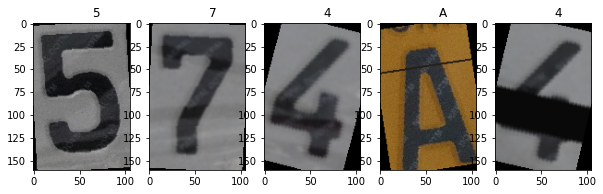

In [7]:
def train_imshow():
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
               'A', 'B', 'F')  # Defining the classes we have
    dataiter = iter(train_load)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0))
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()


train_imshow()

torch.Size([3, 160, 105])


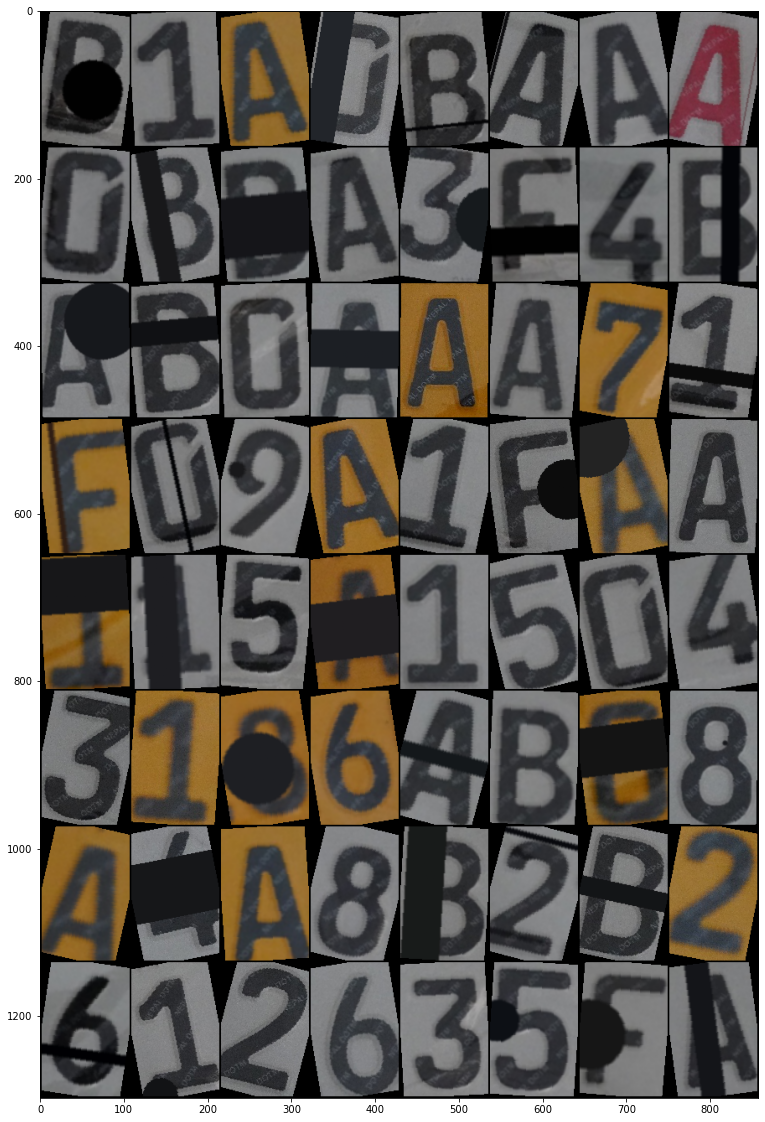

In [8]:
dataiter = iter(train_load)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(images[1].shape)

#### Model

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Layer 1
        self.cnn11 = nn.Conv2d(in_channels=3, out_channels=16,
                               kernel_size=3, stride=1, padding=1)
        self.cnn12 = nn.Conv2d(in_channels=16, out_channels=16,
                               kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)

        # Layer 2
        self.cnn21 = nn.Conv2d(in_channels=16, out_channels=32,
                               kernel_size=3, stride=1, padding=0)
        self.cnn22 = nn.Conv2d(in_channels=32, out_channels=32,
                               kernel_size=3, stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(32)

        # Layer 3
        self.cnn31 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=3, stride=1, padding=0)
        self.cnn32 = nn.Conv2d(in_channels=64, out_channels=64,
                               kernel_size=3, stride=1, padding=0)
        self.batchnorm3 = nn.BatchNorm2d(64)

        # Layer 4
        self.cnn41 = nn.Conv2d(in_channels=64, out_channels=128,
                               kernel_size=3, stride=1, padding=0)
        self.cnn42 = nn.Conv2d(in_channels=128, out_channels=128,
                               kernel_size=3, stride=1, padding=0)
        self.cnn43 = nn.Conv2d(in_channels=128, out_channels=128,
                               kernel_size=3, stride=1, padding=0)
        self.batchnorm4 = nn.BatchNorm2d(128)

        # Flatten
        self.fc1 = nn.Linear(in_features=2304, out_features=500)
        self.droput = nn.Dropout(p=0.5)  # Dropout used to reduce overfitting
        self.fc2 = nn.Linear(in_features=500, out_features=13)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(
            kernel_size=2, stride=2, padding=0, ceil_mode=True)

    def forward(self, x):
        # Layer 1
        out = self.cnn11(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.cnn12(out)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        # Layer 2
        out = self.cnn21(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.cnn22(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        # Layer 3
        out = self.cnn31(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.cnn32(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        # Layer 4
        out = self.cnn41(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.cnn42(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.cnn43(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.maxpool(out)
        #Flattening is done here with .view() -> (batch_size, 128*6*3) = (100, 2304)
        # -1 will automatically update the batchsize as 100; 2304 flattens 128,6,3
        out = out.view(-1, 2304)
        #Then we forward through our fully connected layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

In [10]:
model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from torchsummary import summary
summary(model, (3, 160, 105))

#### Trainng & Testing

In [12]:
%%time
import time

#Define the lists to store the results of loss and accuracy
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Training
def train_model(num_epochs):
  for epoch in range(num_epochs):
    start = time.time()

    # Training Model
    running_loss = 0.0
    correct = 0
    iterations = 0
    n_total = 0
    iter_loss = 0.0

    for i, data in enumerate(train_load):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      iter_loss += loss.data.item()      # Accumulate the loss

      # backward + optimize
      loss.backward()
      optimizer.step()

      # Record the correct predictions for training data
      _, predicted = torch.max(outputs, 1)
      n_total += labels.size(0)
      correct += (predicted == labels).sum()
      iterations += 1

    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / n_total))

    # Testing Evaluation
    loss = 0.0
    correct = 0
    n_total = 0
    iterations = 0

    model.eval()    # Put network in evaluation mode
    for i, data in enumerate(test_load):
      inputs, labels = data
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss += loss.data.item()
      _, predicted = torch.max(outputs, 1)
      n_total += labels.size(0)
      correct += (predicted == labels).sum()

      iterations += 1

    # Record the Testing loss
    val_loss.append(loss/iterations)
    # Record the Testing Accuracy
    val_accuracy.append((100 * correct / n_total))

    stop = time.time()

    print('Epoch [{}/{}], Training Loss: {}, Training Acc.: {}, Validation Loss: {}, Validation Acc.: {}, Time: {}s'
          .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], val_loss[-1], val_accuracy[-1], stop-start))

    save_path = f'./Checkpoints/adv_train2/model-epoch-{epoch+1}.pth'
    torch.save(model, save_path)
    save_path = f'./Checkpoints/adv_train2/model-epoch-{epoch+1}-statedict.pth'
    torch.save(model.state_dict(), save_path)

  print('Finished Training')


train_model(num_epochs)

# Run this if you want to save the model
# PATH_m = '/content/drive/MyDrive/Major Project/Working/models/ALPR_cnn_model.pth'  # Drive
# PATH_m = 'D:\Segments_Sorted/ALPR_cnn_model_statedict.pth'  # HPC
# torch.save(model.state_dict(), '/content/drive/MyDrive/Major Project/Working/models/ALPR_cnn_model_color_10_statedict.pth')
# torch.save(model, PATH_m)

# Loading the trained network
# model.load_state_dict(torch.load(PATH_m))

Epoch [1/300], Training Loss: 2.467870831489563, Training Acc.: 18.32151222229004, Validation Loss: 1.2226123809814453, Validation Acc.: 25.11848258972168, Time: 194.97174286842346s
Epoch [2/300], Training Loss: 2.3242649010249545, Training Acc.: 26.004728317260742, Validation Loss: 1.020955204963684, Validation Acc.: 30.805686950683594, Time: 171.2000629901886s
Epoch [3/300], Training Loss: 2.0094023602349416, Training Acc.: 37.70685577392578, Validation Loss: 0.7349050641059875, Validation Acc.: 43.127960205078125, Time: 173.71157097816467s
Epoch [4/300], Training Loss: 1.0796438455581665, Training Acc.: 67.37588500976562, Validation Loss: 0.27380654215812683, Validation Acc.: 80.09478759765625, Time: 156.78809595108032s
Epoch [5/300], Training Loss: 0.5958269983530045, Training Acc.: 80.85106658935547, Validation Loss: 0.28491923213005066, Validation Acc.: 85.78199005126953, Time: 156.34021997451782s
Epoch [6/300], Training Loss: 0.39242876533951077, Training Acc.: 88.17967224121094

In [ ]:
# PATH_m ='/content/drive/MyDrive/Major Project/Working/Checkpoints/checkpoints_CV/model-fold-1-19.pth' # Drive
# model.load_state_dict(torch.load(PATH_m))

#### Results

In [ ]:
print('[INFO] Plotting after 4 epochs:')
# Plotting the training and validation loss
# plt.plot(train_loss[13:], label='Training Loss')
plt.plot(val_loss[13:], label='Validation Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.plot(train_accuracy[13:], label='Training Accuracy')
plt.plot(val_accuracy[13:], label='Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
selection = 4

fig, ax1 = plt.subplots()
x = [i for i in range(15, 51)]
color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('train_loss', color=color)
ax1.plot(x, train_loss[selection:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# we already handled the x-label with ax1
ax2.set_ylabel('test_loss', color=color)
ax2.plot(x, val_loss[selection:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(13)]
  n_class_samples = [0 for i in range(13)]
  batch_size = 100
  for images, labels in test_load:
      outputs = model(images)
      # max returns (value ,index)
      _, predicted = torch.max(outputs, 1)
      n_samples += labels.size(0)
      n_correct += (predicted == labels).sum().item()
      # print(labels.size())
      for i in range(len(labels)):
          label = labels[i]
          pred = predicted[i]
          if (label == pred):
              n_class_correct[label] += 1
          n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(13):
      acc = 100.0 * n_class_correct[i] / n_class_samples[i]
      print(f'Accuracy of {classes[i]}: {acc} %')


In [ ]:
# Print Prediction

#make an iterator from test_loader
#Get a batch of training images
test_iterator = iter(test_load)
images, labels = test_iterator.next()

results = model(images)
_, predicted = torch.max(results, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

rows = 2
columns = 5
fig = plt.figure(figsize=(13,7))
for i in range(10):
   fig.add_subplot(rows, columns, i+1)
   plt.title('truth ' + classes[labels[i]] + ': predict ' + classes[predicted[i]])
   img = images[i]  # this is to unnormalize the image
   img = torchvision.transforms.ToPILImage()(img)
   plt.imshow(img)
plt.show()

In [ ]:
# Checking image confidence

#make an iterator from test_loader
#Get a batch of training images
test_iterator = iter(test_load)
images, labels = test_iterator.next()


def imshow2(img):
    img = img
    npimg = img.numpy()
    plt.figure(figsize=(5, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


imshow2(images[0, :, :, :])

# classify the image and extract the predictions
print("[INFO] classifying image...")
with torch.no_grad():
    output = model(images)

probabilities = torch.nn.Softmax(dim=-1)(output)
sortedProba = torch.argsort(probabilities, dim=-1, descending=True)
predictions = np.argmax(list(probabilities.numpy()), axis=1)

# loop over the predictions and display the rank-13 predictions and
# corresponding probabilities to our terminal
for (i, idx) in enumerate(sortedProba[0, :13]):
  print("{}: {:.3f}%".format(
      classes[idx.item()].strip(), probabilities[0, idx.item()] * 100))

# print(sortedProba[0,0].numpy())
# print('Predictions: ', predictions)
